<a href="https://colab.research.google.com/github/tuanng007/LoanDefaultPrediction/blob/main/Loan_Prediction_Part_2_Group18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style=color:red>Give Me Some Credit</h1>

<h3 style=color:red>Import Libraries, Functions & Data</h3>

In [ ]:
import os                                     # Importing files.
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import pylab as pl

# Displaying figures.
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# Displaying tabulated data.
from IPython.display import HTML, display
import tabulate
tabulate.PRESERVE_WHITESPACE = False

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

def examinePercentiles(data, percentile_threshold, step_size = 0.001):
    """
        # Purpose: To examine the bucketiting of data above a threshold percentile. Used to detect outliers.
        # Inputs:
        #    data :  list   : Data to examine.
        #    percentile_threshold:  dbl   :  Upper percentile threshold cut-off.
        #    step_size  : dbl : Increments for buckets.
    """
    i = percentile_threshold;
    number_of_points = np.empty((0))
    percentile = np.empty((0))
    cut_off = np.empty((0))
    number_of_points_in_current_bin = np.empty((0))
    while (i<1):
        i = i + step_size
        if i>1:
            i=1

        if len(percentile)<1:
            number_of_points_up_to_previous_bin = 0
        else:
            number_of_points_up_to_previous_bin = sum(data <= data.quantile(percentile[-1]))

        number_of_points_up_to_current_bin = sum(data <= data.quantile(i))
        number_of_points_in_current_bin = np.append(number_of_points_in_current_bin, number_of_points_up_to_current_bin - number_of_points_up_to_previous_bin)
        number_of_points = np.append(number_of_points, number_of_points_up_to_current_bin)
        cut_off = np.append(cut_off, round(data.quantile(i),2))

        percentile = np.append(percentile, round(i,4))
        if len(percentile)>0:
            continue
            #print( "cur bin:" + str(number_of_points_up_to_current_bin) +  " pre bin: " + str(number_of_points_up_to_previous_bin) + " Last percentile: " + str(percentile[-1]) + " Curr percentile: " + str(i) )
    df = pd.DataFrame(data = np.column_stack((percentile,number_of_points,number_of_points_in_current_bin, cut_off)), columns = ['Percentile','# Examples to Percentile','# Examples in bin','Example Level'])
    return df

def createCorrelationHeatMap(data):
    """ Purpose: To generate a correlation heatmap of the data. """
    corr = data.corr()
    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(corr, annot=True, fmt='.2f', cmap = "RdBu_r",xticklabels=True, yticklabels=True, cbar=True)

    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')



    fig.tight_layout()
    plt.show()

def plot_roc_curve(false_positive_rate, true_positive_rate, label="ROC Curve"):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=1)
    plt.plot([0,1],[0,1], "r--")
    plt.axis([0,1,0,1])

    plt.xlabel("False Positive Rate", color='black')
    plt.ylabel("True Positive rate", color='black')

    title_obj = ax.set_title(label, color='black')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.grid(True, which='major', color='gray', linestyle='--')
    fig.tight_layout()
    plt.show()


def plot_feature_importances(clf):
    """
        Purpose: To plot the importance of features fitted.
        Input: The model fit.
    """
    if 'X' not in globals() or not hasattr(X, 'columns'):
        print("Lỗi: DataFrame 'X' chứa tên các feature chưa được định nghĩa.")
        print("Hãy chắc chắn rằng bạn đã chạy cell định nghĩa X = train_df.drop(...) trước khi gọi hàm này.")
        return

    n_features = X.shape[1]

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)

    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        xlabel_text = 'Feature Importance'
        title_text = "Feature Importance for Model"
    elif hasattr(clf, 'coef_'): # Xử lý cho Logistic Regression
        importances = np.abs(clf.coef_[0])
        xlabel_text = 'Absolute Coefficient Value'
        title_text = "Feature Importance for Logistic Regression (Absolute Coefficients)"
    else:
        print("Model type not supported for feature importance plot.")
        return

    sorted_idx = np.argsort(importances) # Sắp xếp để dễ nhìn

    plt.barh(range(n_features), importances[sorted_idx], align='center')
    plt.yticks(np.arange(n_features), X.columns[sorted_idx], color='black') # Đổi màu nhãn y-ticks thành đen
    plt.xlabel(xlabel_text, color='black') # Đổi màu nhãn x-axis thành đen
    plt.ylabel('Feature', color='black')   # Đổi màu nhãn y-axis thành đen
    plt.ylim(-1, n_features)
    plt.grid(True, which='major', color='gray', linestyle='--') # Sửa plt.grid(b=True,...)

    title_obj = ax.set_title(title_text, color='black') # Đổi màu tiêu đề thành đen
    # plt.setp(title_obj, color='black') # Hoặc dùng cách này

    ax.tick_params(axis='x', colors='black') # Đổi màu x-ticks thành đen
    ax.tick_params(axis='y', colors='black') # Đảm bảo màu y-ticks là đen

    fig.tight_layout()
    plt.show()

In [ ]:
working_directory = os.getcwd()
data_path = "data"
file_training = "cs-training.csv"
file_testing = "cs-test.csv"

file_full_path_training = os.path.join(working_directory, data_path, file_training)
file_full_path_testing = os.path.join(working_directory, data_path, file_testing)

if not os.path.exists(file_full_path_training):
    print("Could not find file: " + file_full_path_training)
else:
    train_df = pd.read_csv(file_full_path_training)
    test_df = pd.read_csv(file_full_path_testing)

<h3 style=color:lightblue>Descriptive Statistics</h3>

In [ ]:
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
test_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [ ]:
train_df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
test_df.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

In [ ]:
train_df.describe().round(decimals=2)

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


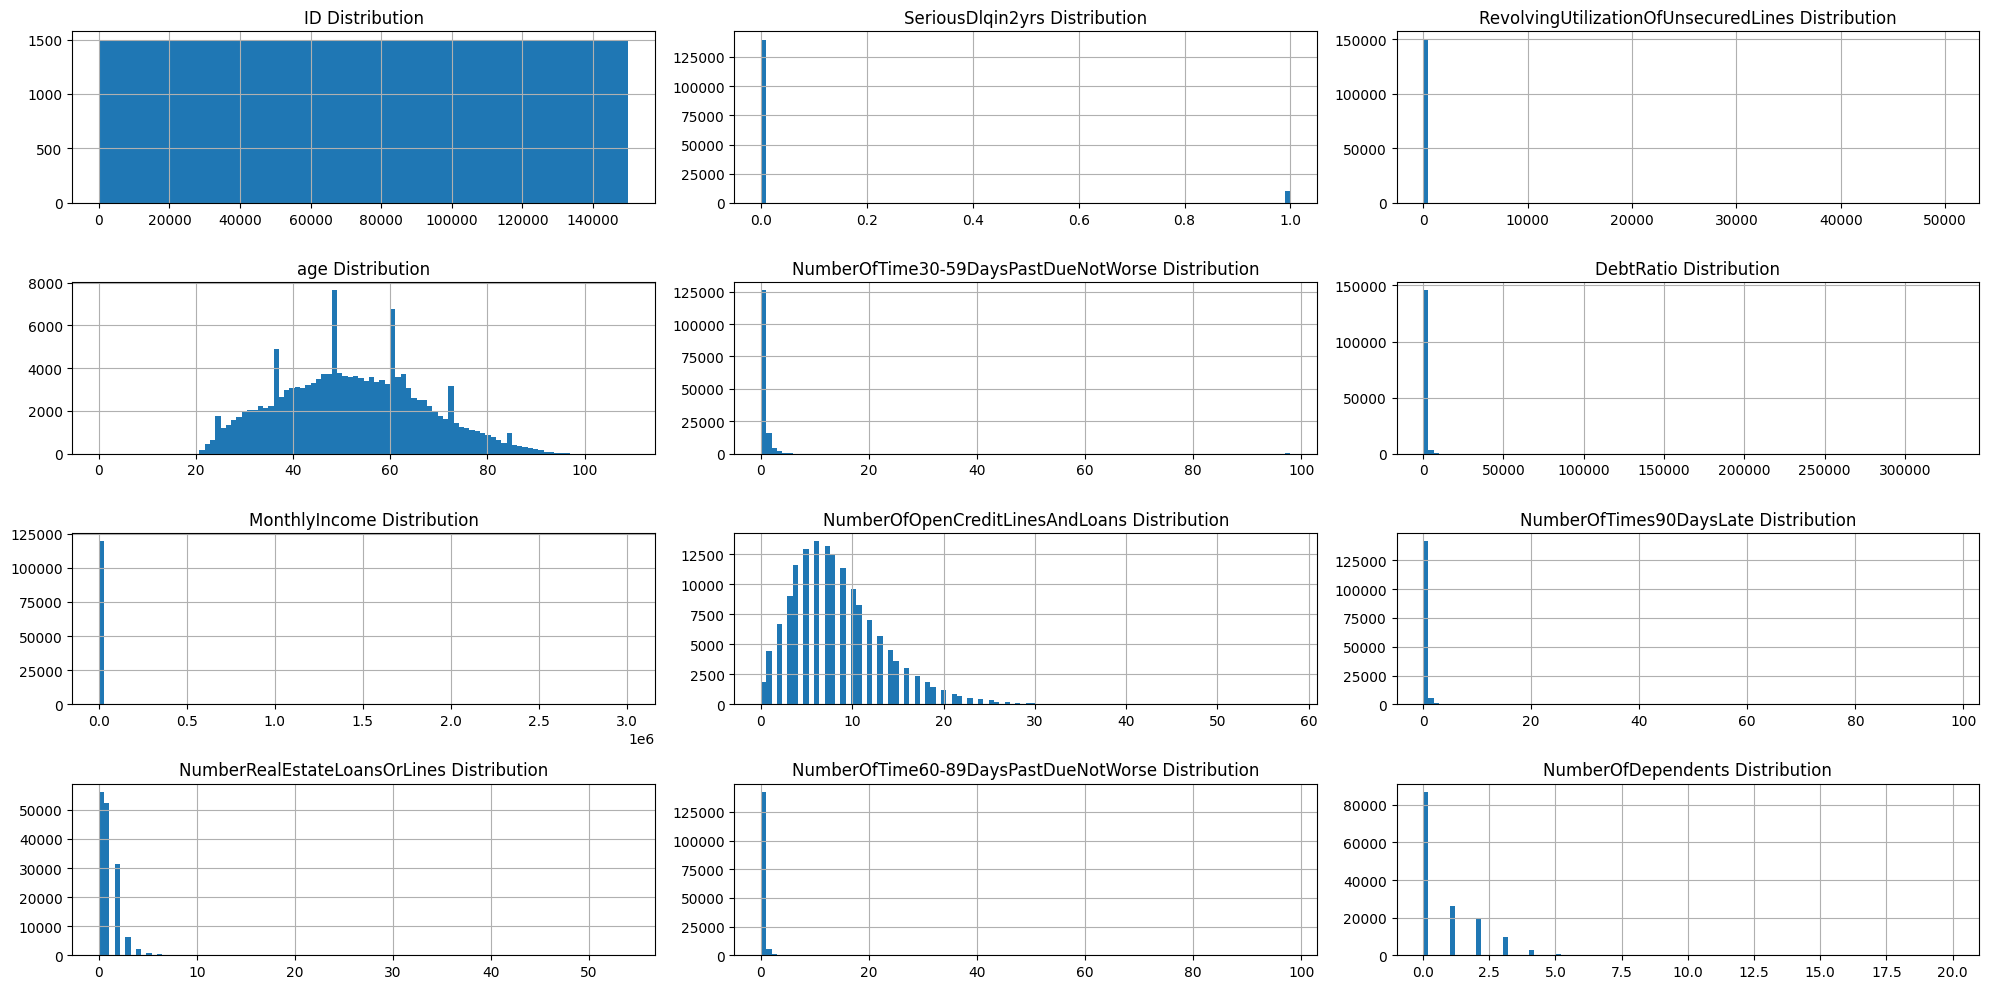

In [ ]:
import matplotlib.pyplot as plt # Đảm bảo plt đã được import

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=100,ax=ax)

        title_obj = ax.set_title(var_name+" Distribution", color='black') # Đặt màu tiêu đề trực tiếp


        ax.tick_params(axis='x', colors='black')       # Đặt màu cho các tick labels trục X
        ax.tick_params(axis='y', colors='black')       # Đặt màu cho các tick labels trục Y

    fig.tight_layout()
    plt.show()

    fig.tight_layout()
    plt.show()
draw_histograms(train_df, train_df.columns, 4, 3)

In [ ]:
print(train_df.duplicated().value_counts())
print(test_df.duplicated().value_counts())

False    150000
Name: count, dtype: int64
False    101503
Name: count, dtype: int64


In [ ]:
def missing_values_table(df):
    """ Purpose: To examine a Pandas dataframe and output the list of columns with missing data (NaN or blanks).
        Returns: DataFrame with two columns.  Missing Values    AND   Missing as a % of Total Values.
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(train_df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MonthlyIncome,29731,19.8
NumberOfDependents,3924,2.6


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Log Monthlty income')

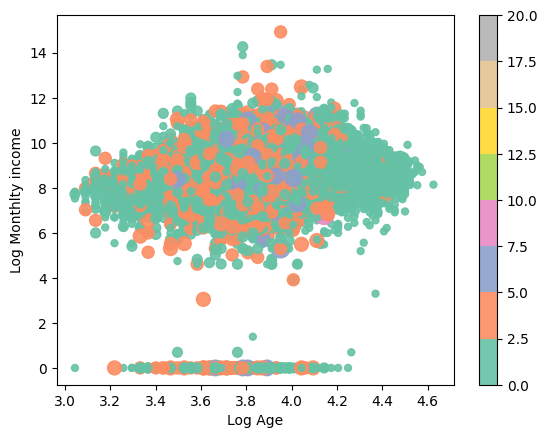

In [ ]:
plt.scatter(x=np.log(train_df['age']),y=np.log(train_df['MonthlyIncome']),alpha=.9,
            s=train_df['NumberOfDependents']*25,c=train_df.NumberOfDependents,cmap='Set2')
plt.colorbar()
plt.xlabel('Log Age')
plt.ylabel('Log Monthlty income')

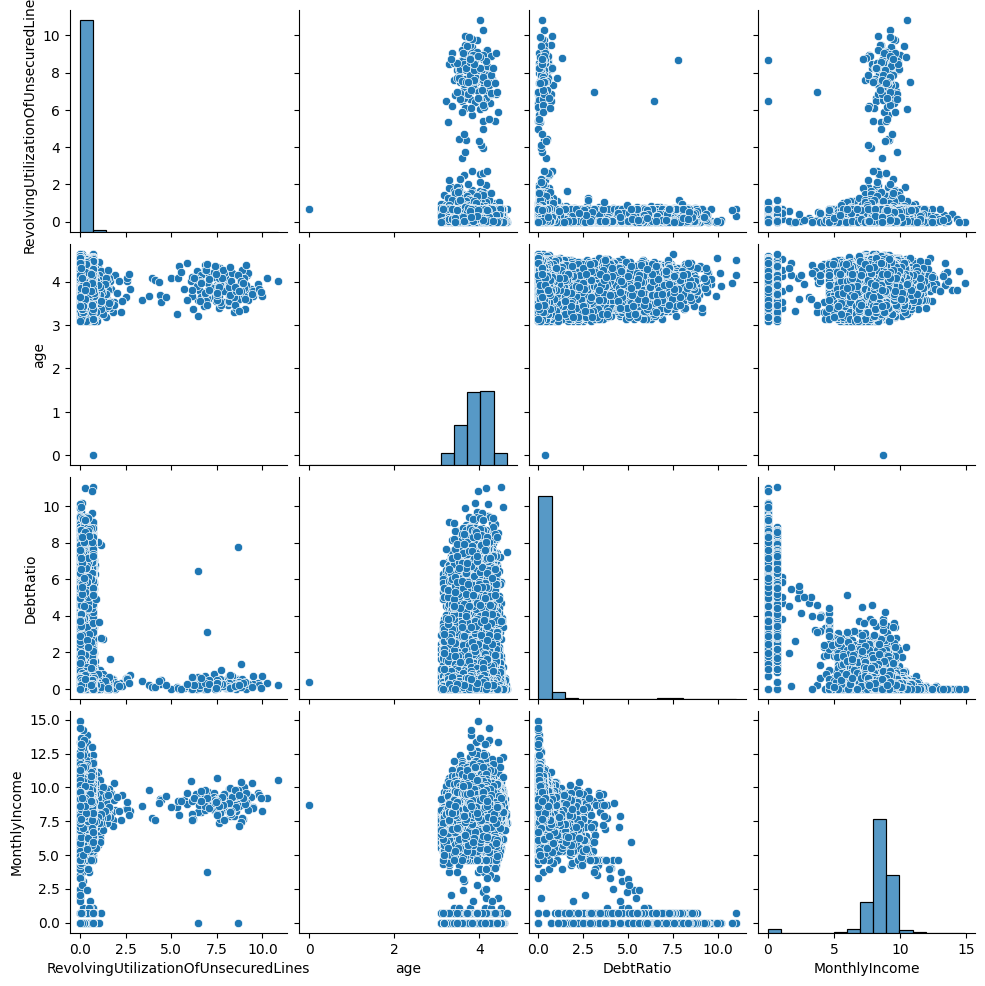

In [ ]:
sns.pairplot(np.log(train_df[['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome']]+1).dropna(axis=0,how='any'),
             diag_kws=dict(bins=15,edgecolor='black'))

In [ ]:
def createCorrelationHeatMap(data):
    """ Purpose: To generate a correlation heatmap of the data. """
    corr = data.corr()
    fig = plt.figure(figsize=(10,10))
    ax = sns.heatmap(corr, annot=True, fmt='.2f', cmap = "RdBu_r",xticklabels=True, yticklabels=True, cbar=True)
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')       #set the color of xticks
    ax.tick_params(axis='y', colors='white')       #set the color of yticks
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

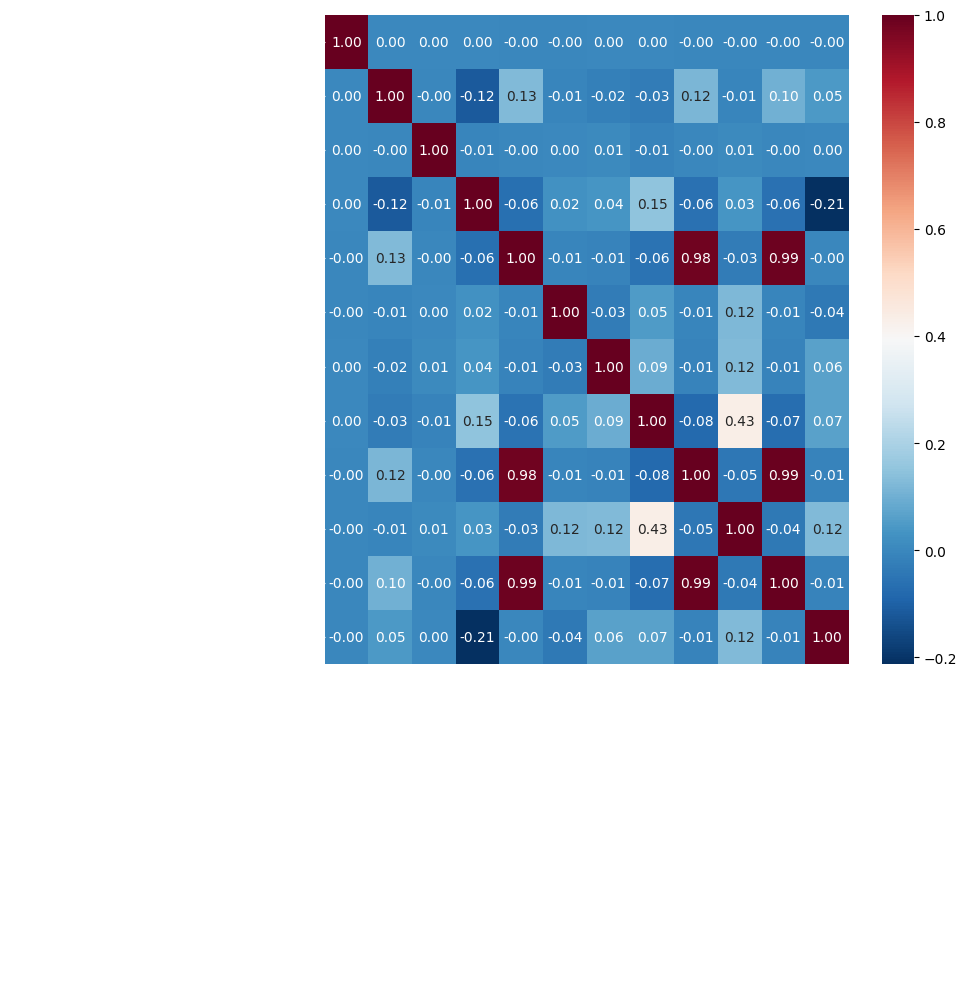

In [ ]:
createCorrelationHeatMap(train_df)

In [ ]:
## Kiểm tra kiểu dữ liệu của các cột trong train_df
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

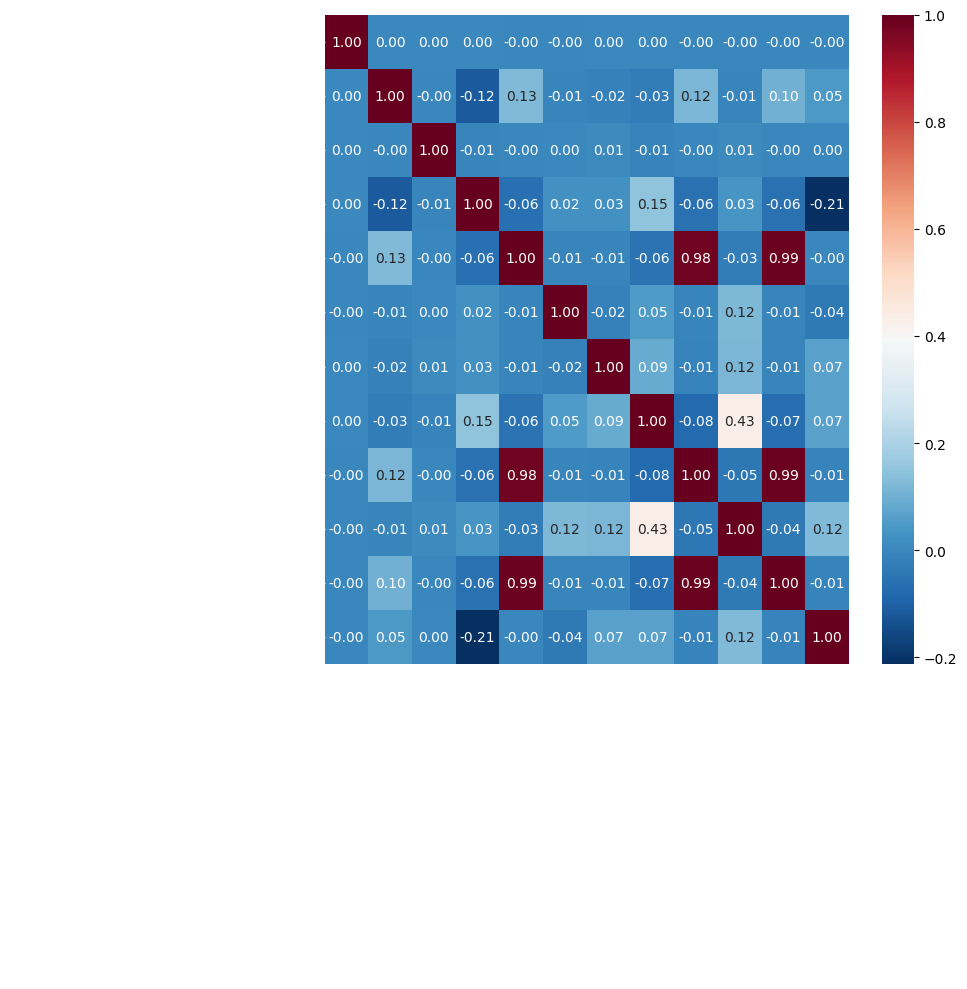

In [ ]:
train_df['MonthlyIncome'] = pd.to_numeric(train_df['MonthlyIncome'], errors='coerce')


train_df['MonthlyIncome'] = train_df['MonthlyIncome'].replace(np.nan,train_df['MonthlyIncome'].median())


createCorrelationHeatMap(train_df)

<h3 style=color:red>Examining the Features</h3>

<h4 style=color:red>SeriousDlqin2yrs</h4>

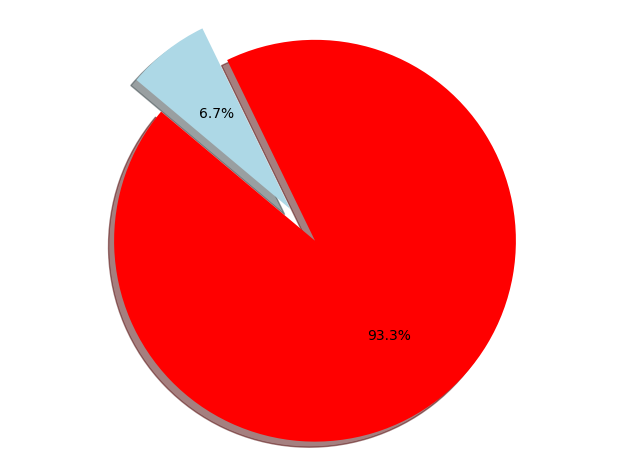

,SeriousDlqin2yrs,Count,percent
0,0.00,139974.00,93.32
1,1.00,10026.00,6.68


In [ ]:
nos = sum(train_df["SeriousDlqin2yrs"] == 0);
yeses = sum(train_df["SeriousDlqin2yrs"] == 1);
total = len(train_df["SeriousDlqin2yrs"]);

# Data to plot
labels = 'NO', 'YES'
sizes = [nos, yeses]
colors = ['red', 'lightblue']
explode = (0.2, 0)  # explode 1st slice

# Plot
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140);

for text in texts:
    text.set_color('white')
for autotext in autotexts:
    autotext.set_color('black')

plt.axis('equal');                   # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout();
plt.show();

percent = train_df.groupby('SeriousDlqin2yrs')['ID'].count().reset_index()
percent['percent'] = 100 * percent['ID'] / percent['ID'].sum()
percent.rename(columns={'ID':'Count'}, inplace=True)
display(HTML(tabulate.tabulate(percent, headers=percent.columns, floatfmt=".2f", tablefmt='html')))

<h4 style=color:red>age</h4>

In [ ]:
train_df.loc[train_df['age'] < 21]

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


<p style=color:red>There is one data point with an age value of zero. Resetting this value to the median.</p>

In [ ]:
#train_df.loc[train_df['age'] == 0, 'age'] = train_df['age'].median()

In [ ]:
age_workforce = train_df.loc[(train_df['age'] >= 21) & (train_df['age'] <= 65)]
age_retired = train_df.loc[(train_df['age'] > 65)]
print("workforce ave salary:" + str(round(age_workforce['MonthlyIncome'].mean(),0)))
print("retiree ave salary:" + str(round(age_retired['MonthlyIncome'].mean(),0)))
print("workforce median salary:" + str(round(age_workforce['MonthlyIncome'].median(),0)))
print("retiree median salary:" + str(round(age_retired['MonthlyIncome'].median(),0)))

workforce ave salary:6528.0
retiree ave salary:5953.0
workforce median salary:5400.0
retiree median salary:5400.0


<h4 style=color:red>NumberOfDependents</h4>

In [ ]:
df_results = examinePercentiles(train_df['NumberOfDependents'], 0.99,  0.001)
df_results

,Percentile,# Examples to Percentile,# Examples in bin,Example Level
0,0.991,145085.0,145085.0,4.0
1,0.992,145085.0,0.0,4.0
2,0.993,145085.0,0.0,4.0
3,0.994,145831.0,746.0,5.0
4,0.995,145831.0,0.0,5.0
5,0.996,145831.0,0.0,5.0
6,0.997,145831.0,0.0,5.0
7,0.998,145831.0,0.0,5.0
8,0.999,145989.0,158.0,6.0
9,1.000,146076.0,87.0,20.0


In [ ]:
train_df['NumberOfDependents'].value_counts().sort_index()

,count
NumberOfDependents,
0.0,86902
1.0,26316
2.0,19522
3.0,9483
4.0,2862
5.0,746
6.0,158
7.0,51
8.0,24


<h4 style=color:red>NumberOfTime30-59DaysPastDueNotWorse</h4>

In [ ]:
train_df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts().sort_index()

,count
NumberOfTime30-59DaysPastDueNotWorse,
0,126018
1,16033
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25


In [ ]:
df_results = examinePercentiles(train_df['NumberOfTime30-59DaysPastDueNotWorse'], 0.99,  0.001)
df_results

,Percentile,# Examples to Percentile,# Examples in bin,Example Level
0,0.991,149150.0,149150.0,4.0
1,0.992,149150.0,0.0,4.0
2,0.993,149150.0,0.0,4.0
3,0.994,149150.0,0.0,4.0
4,0.995,149492.0,342.0,5.0
5,0.996,149492.0,0.0,5.0
6,0.997,149632.0,140.0,6.0
7,0.998,149711.0,79.0,8.0
8,0.999,150000.0,289.0,98.0
9,1.000,150000.0,0.0,98.0


<h4 style=color:red>NumberOfTimes90DaysLate</h4>

In [ ]:
train_df['NumberOfTimes90DaysLate'].value_counts().sort_index()

,count
NumberOfTimes90DaysLate,
0,141662
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21


In [ ]:
df_results = examinePercentiles(train_df['NumberOfTimes90DaysLate'], 0.99,  0.001)
df_results

,Percentile,# Examples to Percentile,# Examples in bin,Example Level
0,0.991,149127.0,149127.0,3.0
1,0.992,149127.0,0.0,3.0
2,0.993,149127.0,0.0,3.0
3,0.994,149127.0,0.0,3.0
4,0.995,149418.0,291.0,4.0
5,0.996,149418.0,0.0,4.0
6,0.997,149629.0,211.0,6.0
7,0.998,149707.0,78.0,9.0
8,0.999,150000.0,293.0,98.0
9,1.000,150000.0,0.0,98.0


<h4 style=color:red>NumberOfTime60-89DaysPastDueNotWorse</h4>

In [ ]:
train_df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts().sort_index()

,count
NumberOfTime60-89DaysPastDueNotWorse,
0,142396
1,5731
2,1118
3,318
4,105
5,34
6,16
7,9
8,2


In [ ]:
df_results = examinePercentiles(train_df['NumberOfTime60-89DaysPastDueNotWorse'], 0.99,  0.001)
df_results

,Percentile,# Examples to Percentile,# Examples in bin,Example Level
0,0.991,149245.0,149245.0,2.0
1,0.992,149245.0,0.0,2.0
2,0.993,149245.0,0.0,2.0
3,0.994,149245.0,0.0,2.0
4,0.995,149563.0,318.0,3.0
5,0.996,149563.0,0.0,3.0
6,0.997,149563.0,0.0,3.0
7,0.998,149702.0,139.0,5.0
8,0.999,150000.0,298.0,98.0
9,1.000,150000.0,0.0,98.0


In [ ]:
def replaceSpuriousValues96and98(data):
    """ Purpose: To replace the example values 96 or 98 with the median from the feature. """
    # Remove the 96 and 98 values from the median calculation.
    new_data = data[data!=96]
    new_data = new_data[new_data!=98]

    new = []
    newval = new_data.median()
    for i in data:
        if (i == 96 or i == 98):
            new.append(newval)
        else:
            new.append(i)
    return new

train_df['NumberOfTime30-59DaysPastDueNotWorse'] = replaceSpuriousValues96and98(train_df['NumberOfTime30-59DaysPastDueNotWorse'])
train_df['NumberOfTimes90DaysLate'] = replaceSpuriousValues96and98(train_df['NumberOfTimes90DaysLate'])
train_df['NumberOfTime60-89DaysPastDueNotWorse'] = replaceSpuriousValues96and98(train_df['NumberOfTime60-89DaysPastDueNotWorse'])


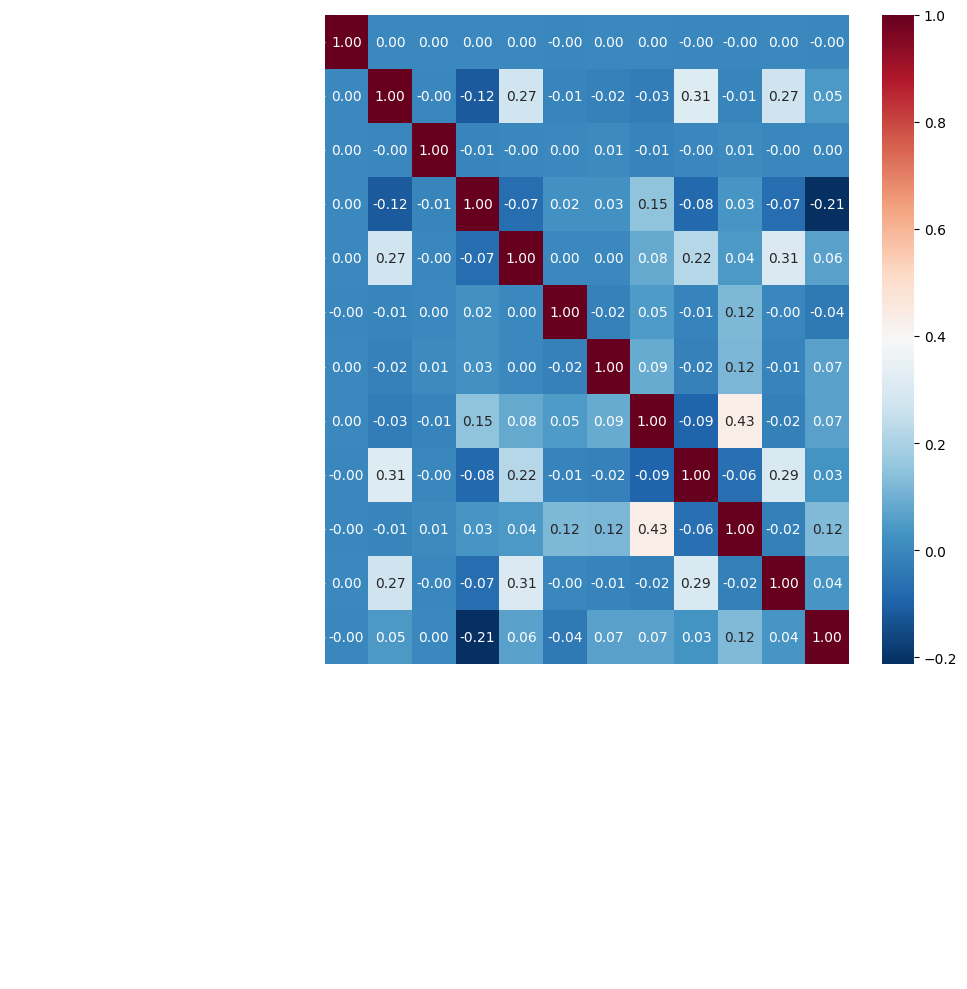

In [ ]:
createCorrelationHeatMap(train_df)

<h3 style=color:red>Imputing</h3>

In [ ]:
# Alter for both training and testing data.
train_df.loc[train_df['age'] == 0, 'age'] = train_df['age'].median()
train_df['MonthlyIncome'] = train_df['MonthlyIncome'].replace(np.nan,train_df['MonthlyIncome'].median())
train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median(), inplace=True)

test_df.loc[test_df['age'] == 0, 'age'] = test_df['age'].median()
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].replace(np.nan,test_df['MonthlyIncome'].mean())
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].median(), inplace=True)

<ipython-input-34-2439021159>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median(), inplace=True)
<ipython-input-34-2439021159>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

<h3 style=color:red>Model Training</h3>

In [ ]:
# Training data:
X = train_df.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = train_df['SeriousDlqin2yrs']
# Testing data:
W = test_df.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
z = test_df['SeriousDlqin2yrs']

<h4 style=color:red>Cross Validation - two splits- training, test</h4>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123, test_size = 0.25)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


<h4 style=color:red>Logistic Regression</h4>

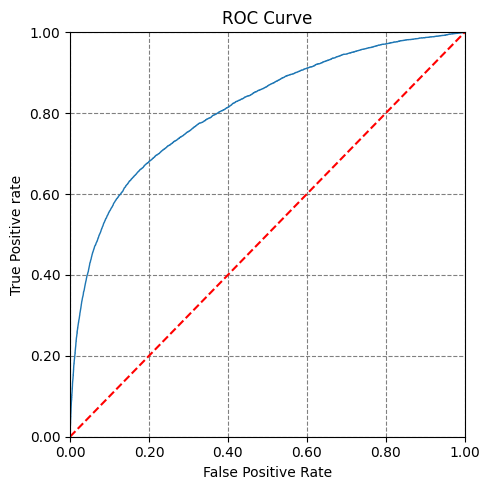

0.8116500277402092
AUC Score :  0.81165


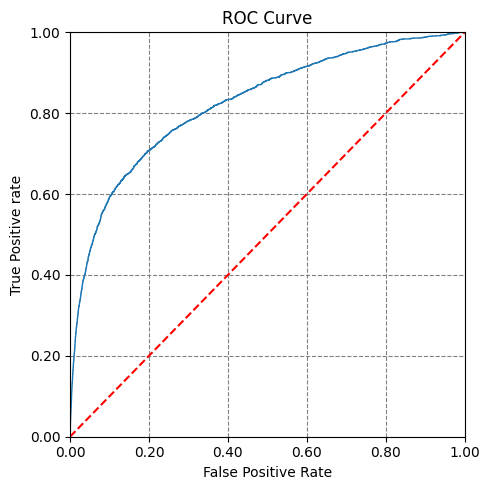

AUC Score :  0.8250861
F1 Score :  0.3580935

--- Evaluation for LogisticRegression (Test Set) ---
Confusion Matrix:
[[30283  4755]
 [  888  1574]]


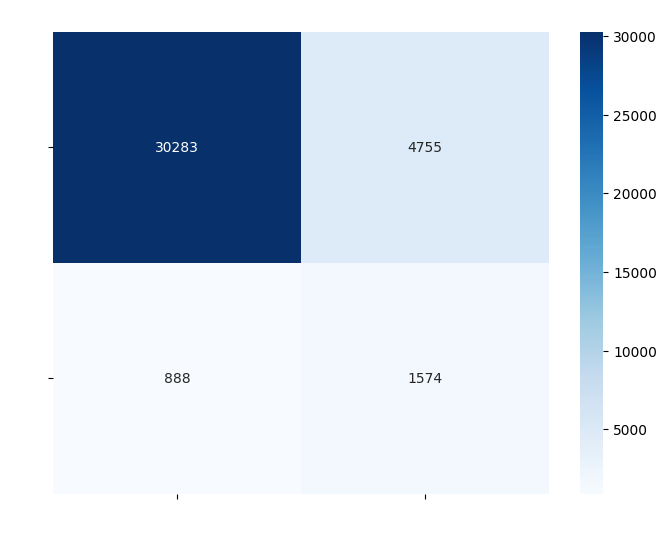


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     35038
           1       0.25      0.64      0.36      2462

    accuracy                           0.85     37500
   macro avg       0.61      0.75      0.64     37500
weighted avg       0.92      0.85      0.88     37500

------------------------------------------------------------


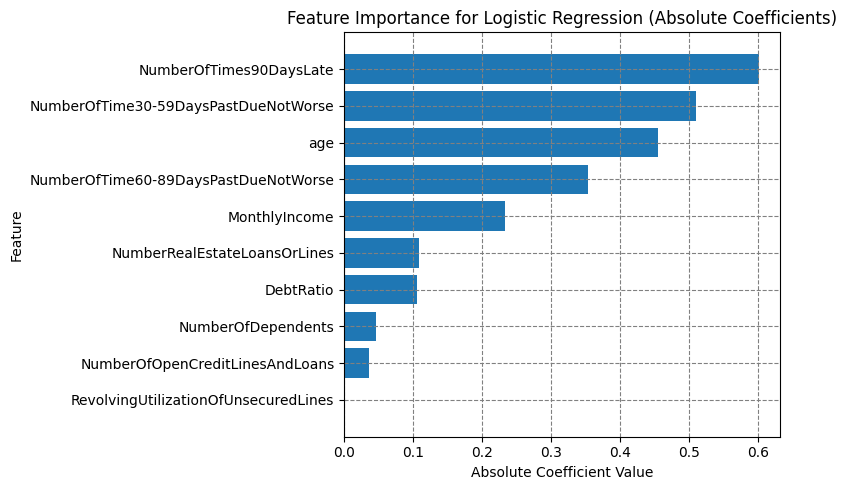

In [ ]:
# In sample fit:
import sklearn.metrics as metrics
logit = LogisticRegression(random_state=123, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
##logit = LogisticRegression(random_state=123, solver='liblinear', penalty='l1', class_weight=None, C=1.0, max_iter=100, dual=False, tol=0.0001, fit_intercept=True,intercept_scaling=1,  multi_class='ovr', verbose=2)
#logit.fit(X_train, y_train)
logit.fit(X_train_scaled, y_train)
#logit_scores_proba = logit.predict_proba(X_test)
logit_scores_proba = logit.predict_proba(X_train_scaled)
preds = logit_scores_proba[:,1]  # predictions
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
#fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
#print('AUC Score : ', round(roc_auc_score(y_test,preds),7))
print('AUC Score : ', round(roc_auc_score(y_train,preds),7))

# Out-of-sample - unseen test data.
logit_scores_proba_val = logit.predict_proba(X_test_scaled)
preds_proba = logit_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_test, preds_proba)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print('AUC Score : ', round(roc_auc_score(y_test,preds_proba),7))

# Calculate F1 Score
preds = logit.predict(X_test_scaled) # Get binary predictions
f1 = f1_score(y_test, preds)
print('F1 Score : ', round(f1, 7))

y_pred_logit_cv = logit.predict(X_test_scaled)

# Confusion Matrix và Classification Report cho LogisticRegressionCV (Test Set)
print(f"\n--- Evaluation for {type(logit).__name__} (Test Set) ---")
print("Confusion Matrix:")
cm_logit_cv = confusion_matrix(y_test, y_pred_logit_cv)
print(cm_logit_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logit_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted Label', color='white'); plt.ylabel('True Label', color='white')
plt.title(f'Confusion Matrix - {type(logit).__name__} (Test Set)', color='white')
plt.xticks(color='white'); plt.yticks(color='white')
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logit_cv))
print("-" * 60)


plot_feature_importances(logit)

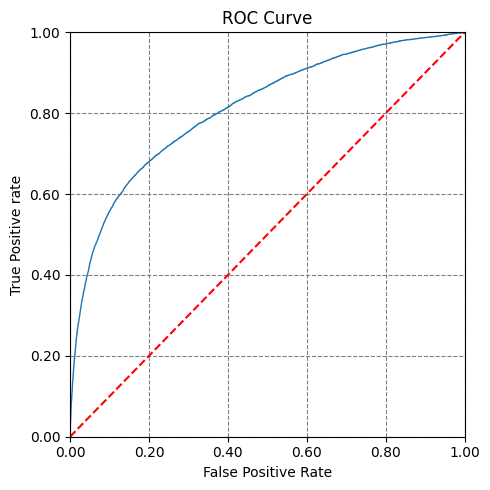

AUC Score (Training) :  0.8116501121511571
F1 Score (Test) :  0.3580935

Confusion Matrix (Test):
[[30283  4755]
 [  888  1574]]


In [ ]:
# Cross Validation
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix

clf = LogisticRegressionCV(Cs=[1, 2, 5, 10], random_state=123, penalty='l1', solver='saga', class_weight='balanced', max_iter=500) # If Cs not specified, default=10.
clf.fit(X_train_scaled, y_train)

clf_scores_proba = clf.predict_proba(X_train_scaled)
clf_scores = clf_scores_proba[:,1]
fpr, tpr, threshold = roc_curve(y_train, clf_scores)
plot_roc_curve(fpr,tpr)
print('AUC Score (Training) : ', (roc_auc_score(y_train,clf_scores)))



y_pred = clf.predict(X_test_scaled)

#  F1 Score
f1 = f1_score(y_test, y_pred)
print('F1 Score (Test) : ', round(f1, 7))

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Test):")
print(cm)

<h4 style=color:red>Random Forest</h4>

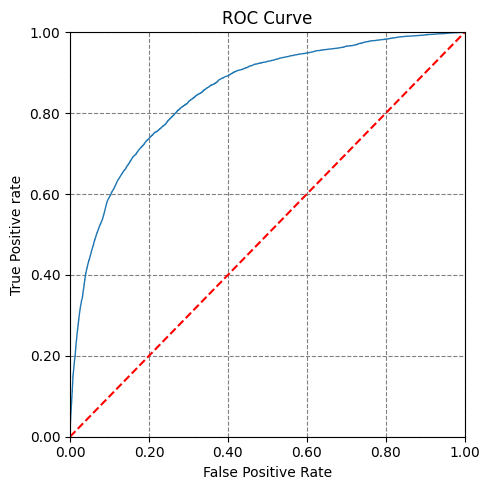

AUC Score :  0.8494760531835537


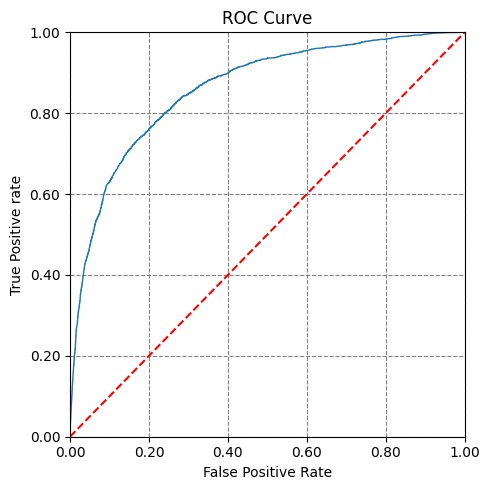

AUC Score :  0.8615738
F1 Score :  0.3086352

--- Evaluation for RandomForestClassifier (Test Set) ---
Confusion Matrix:
[[26737  8301]
 [  498  1964]]


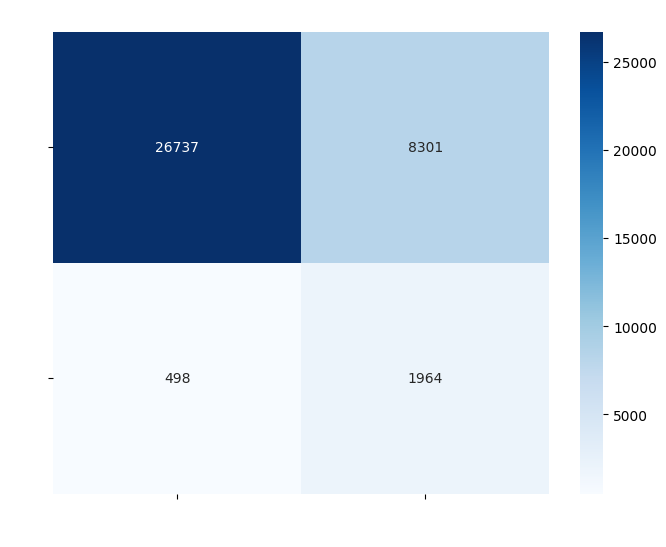


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     35038
           1       0.19      0.80      0.31      2462

    accuracy                           0.77     37500
   macro avg       0.59      0.78      0.58     37500
weighted avg       0.93      0.77      0.82     37500

------------------------------------------------------------


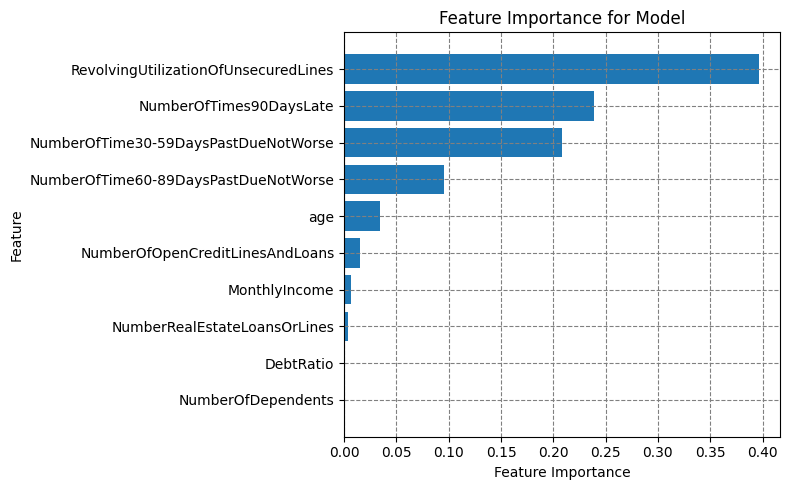

In [ ]:
# Insample
clf = RandomForestClassifier(random_state=123, max_depth=3, n_estimators=300, class_weight='balanced')
clf.fit(X_train_scaled, y_train)
clf_scores_proba = clf.predict_proba(X_train_scaled)    # Predict class probabilities for X.
clf_preds = clf_scores_proba[::,1] # predictions
fpr, tpr, threshold = roc_curve(y_train, clf_preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', (roc_auc_score(y_train,clf_preds)))

# Out-of-sample - unseen test data.
# Note: Ensure rf_scores_proba is correctly assigned in the insample section if using that variable name.
# Assuming clf is the trained Random Forest model here for the out-of-sample section.
clf_scores_proba_val = clf.predict_proba(X_test_scaled) # Use the trained clf model
preds_proba = clf_scores_proba_val[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds_proba)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds_proba),7))

# Calculate F1 Score
preds = clf.predict(X_test_scaled) # Get binary predictions
f1 = f1_score(y_test, preds)
print('F1 Score : ', round(f1, 7))


y_pred_logit_cv = clf.predict(X_test_scaled)

# Confusion Matrix và Classification Report cho LogisticRegressionCV (Test Set)
print(f"\n--- Evaluation for {type(clf).__name__} (Test Set) ---")
print("Confusion Matrix:")
cm_logit_cv = confusion_matrix(y_test, y_pred_logit_cv)
print(cm_logit_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logit_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted Label', color='white'); plt.ylabel('True Label', color='white')
plt.title(f'Confusion Matrix - {type(clf).__name__} (Test Set)', color='white')
plt.xticks(color='white'); plt.yticks(color='white')
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logit_cv))
print("-" * 60)

plot_feature_importances(clf)

**Gradient Boosting**

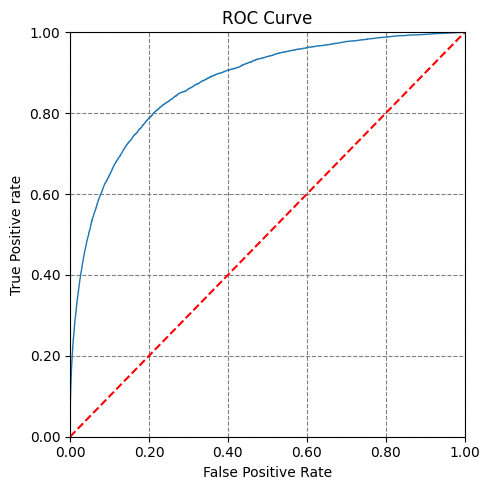

AUC Score :  0.8732199350024615


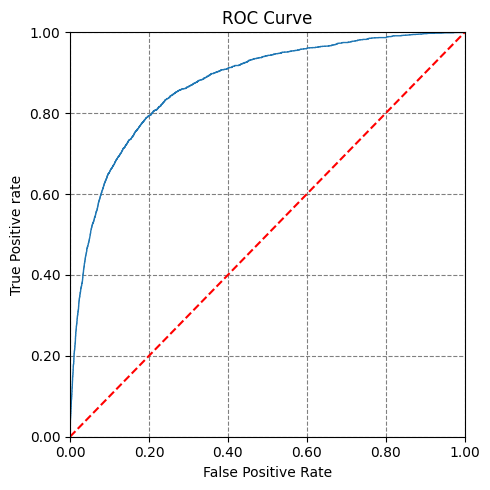

AUC Score :  0.8727478
F1 Score :  0.2811443

--- Evaluation for GradientBoostingClassifier (Test Set) ---
Confusion Matrix:
[[34706   332]
 [ 2005   457]]


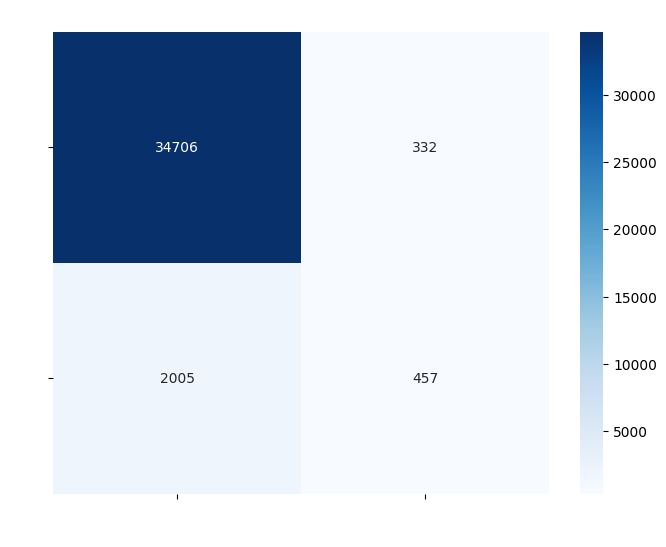


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     35038
           1       0.58      0.19      0.28      2462

    accuracy                           0.94     37500
   macro avg       0.76      0.59      0.62     37500
weighted avg       0.92      0.94      0.92     37500

------------------------------------------------------------


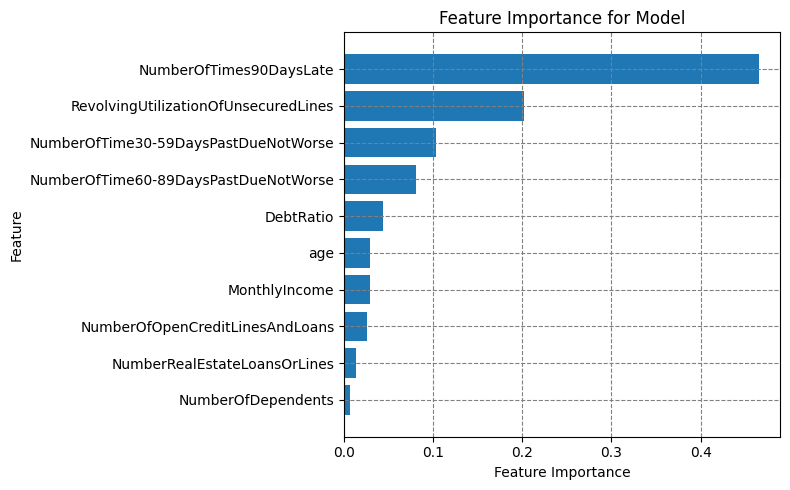

In [ ]:
# In sample. (Using default constructor gave AUC: 0.8628)
clf = GradientBoostingClassifier( random_state=123, n_estimators=150, learning_rate=0.05, max_depth=5)
clf.fit(X_train_scaled, y_train)
# clf_scores_proba = clf.predict_proba(X_train)    # Lỗi tiềm ẩn ở đây nếu X_train chưa được scale
clf_scores_proba = clf.predict_proba(X_train_scaled) # Nên dùng X_train_scaled nếu mô hình fit trên đó
clf_scores = clf_scores_proba[:,1]

fpr, tpr, thresh = roc_curve(y_train, clf_scores)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', (roc_auc_score(y_train, clf_scores))) # Sử dụng clf_scores

# Out-of-sample - unseen test data.
clf_scores_proba_val = clf.predict_proba(X_test_scaled)
preds = clf_scores_proba_val[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
plot_roc_curve(fpr,tpr)
print('AUC Score : ', round(roc_auc_score(y_test,preds),7))

# Calculate F1 Score
preds = clf.predict(X_test_scaled) # Get binary predictions
f1 = f1_score(y_test, preds)
print('F1 Score : ', round(f1, 7))

y_pred_logit_cv = clf.predict(X_test_scaled)

# Confusion Matrix và Classification Report cho LogisticRegressionCV (Test Set)
print(f"\n--- Evaluation for {type(clf).__name__} (Test Set) ---")
print("Confusion Matrix:")
cm_logit_cv = confusion_matrix(y_test, y_pred_logit_cv)
print(cm_logit_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logit_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted Label', color='white'); plt.ylabel('True Label', color='white')
plt.title(f'Confusion Matrix - {type(clf).__name__} (Test Set)', color='white')
plt.xticks(color='white'); plt.yticks(color='white')
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logit_cv))
print("-" * 60)

plot_feature_importances(clf)

In [ ]:
clf = GradientBoostingClassifier(random_state=123, n_estimators=150, learning_rate=0.05 ,max_depth=4)
# Training:
clf.fit(X_train,y_train)
clf_proba = clf.predict_proba(X_train)
clf_scores = clf_proba[:,1]
# Real Testing Data:
clf_test_proba = clf.predict_proba(X_test)
clf_test_scores = clf_test_proba[:,1]

print('AUC Score (training) :', roc_auc_score(y_train, clf_scores))
print('AUC Score (test):', roc_auc_score(y_test, clf_test_scores))

AUC Score (training) : 0.8684623588603597
AUC Score (test): 0.8725185291457264
